In [1]:
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
from zennit.attribution import Gradient, SmoothGrad
from zennit.torchvision import ResNetCanonizer
from zennit.composites import EpsilonGammaBox, EpsilonPlusFlat, EpsilonAlpha2Beta1Flat, EpsilonAlpha2Beta1, EpsilonPlus
from zennit.image import imgify, imsave

In [3]:
from tempo.models import NewTempoLinear

In [4]:
image = Image.open("IMG_0225.png")

In [5]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((128,128))
])

In [6]:
image = transform(image)

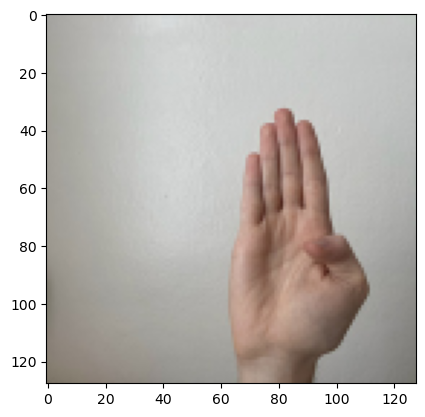

In [7]:
plt.imshow(image.permute(1,2,0))

In [8]:
def noisy(image, factor=0.1):
    row,col,ch= image.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = torch.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + factor*gauss
    return noisy

noisy_image = noisy(image, 0.3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


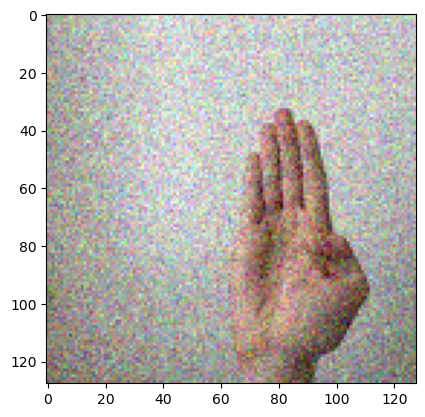

In [9]:
plt.imshow(noisy_image.permute(1,2,0))

In [10]:
def get_heatmap(model, data, num_classes):

    with torch.no_grad():
        _, (idx1, idx2, idx3) = torch.topk(model(data).flatten(), 3)

    canonizer = ResNetCanonizer()

    # low, high = normalize(torch.tensor([[[[[0.]]] * 3], [[[[1.]]] * 3]]))
    # composite = EpsilonGammaBox(low=low, high=high, canonizers=[canonizer])

    # create a composite, specifying the canonizers
    composite = EpsilonPlusFlat(canonizers=[canonizer])

    # composite = EpsilonAlpha2Beta1(canonizers=[canonizer])
    # composite = EpsilonAlpha2Beta1Flat(canonizers=[canonizer])
    


    # choose a target class for the attribution
    target1 = torch.eye(num_classes)[[idx1.item()]]
    # target2 = torch.eye(num_classes)[[idx2.item()]]
    # target3 = torch.eye(num_classes)[[idx3.item()]]

    # create the attributor, specifying model and composite
    with Gradient(model=model, composite=composite) as attributor:
        # compute the model output and attribution
        output1, attribution1 = attributor(data, target1)
        # output2, attribution2 = attributor(data, target2)
        # output3, attribution3 = attributor(data, target3)

    relevance1 = attribution1.sum(1)
    # relevance2 = attribution2.sum(1)
    # relevance3 = attribution3.sum(1)

    return idx1, imgify(relevance1, symmetric=True, cmap='coldnhot')

In [11]:
# MODEL_NAME = "asl_big_e10_p30_run5.pth"
MODEL_NAME = "vanilla.pth"

# load models
weights_tp = torch.load(f'../model_zoo/{MODEL_NAME}')
model_tp = NewTempoLinear(out_features=24, weights=None,freeze_backbone=True)
model_tp.load_state_dict(weights_tp)
model_tp.requires_grad = True
_ = model_tp.eval()

weights_bl = torch.load('../model_zoo/baseline.pth')
model_bl = NewTempoLinear(out_features=24, weights=None,freeze_backbone=True)
model_bl.load_state_dict(weights_bl)
model_bl.requires_grad = True
_ = model_bl.eval()

In [12]:
normalize = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # imagenet normalization, also applied during tempo training

In [13]:
class_map = {
            'A': 0, 
            'B': 1, 
            'C': 2,
            'D': 3,
            'E': 4,
            'F': 5,
            'G': 6,
            'H': 7,
            'I': 8,
            'K': 9,
            'L': 10,
            'M': 11,
            'N': 12,
            'O': 13,
            'P': 14,
            'Q': 15,
            'R': 16,
            'S': 17,
            'T': 18,
            'U': 19,
            'V': 20,
            'W': 21,
            'X': 22,
            'Y': 23,
            }

inv_class_map = {v: k for k, v in class_map.items()}

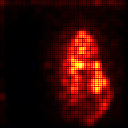

'B'

In [14]:
pred, img_hm = get_heatmap(model_tp, normalize(noisy_image[None]), 24)
display(img_hm)
inv_class_map[pred.item()]

In [15]:
def compare_adv(img_path: str):
    image = Image.open(img_path)
    image = transform(image)

    fig = plt.figure(layout="constrained")
    ax_array = fig.subplots(3, 6, squeeze=False)

    for j in range(6):
        noisy_image = noisy(image, 0.1*j)
        ax_array[0,j].imshow(noisy_image.permute(1,2,0))
        ax_array[0,j].set_title(f"Noise level: {0.1*j:.1f}")


        pred, img_hm = get_heatmap(model_bl, normalize(noisy_image[None]), 24)
        ax_array[0+1,j].imshow(img_hm)
        ax_array[0+1,j].set_title(f"Prediction: {inv_class_map[pred.item()]}")

        pred, img_hm = get_heatmap(model_tp, normalize(noisy_image[None]), 24)
        ax_array[0+2,j].imshow(img_hm)
        ax_array[0+2,j].set_title(f"Prediction: {inv_class_map[pred.item()]}")

    fig.set_size_inches(18.5, 10.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


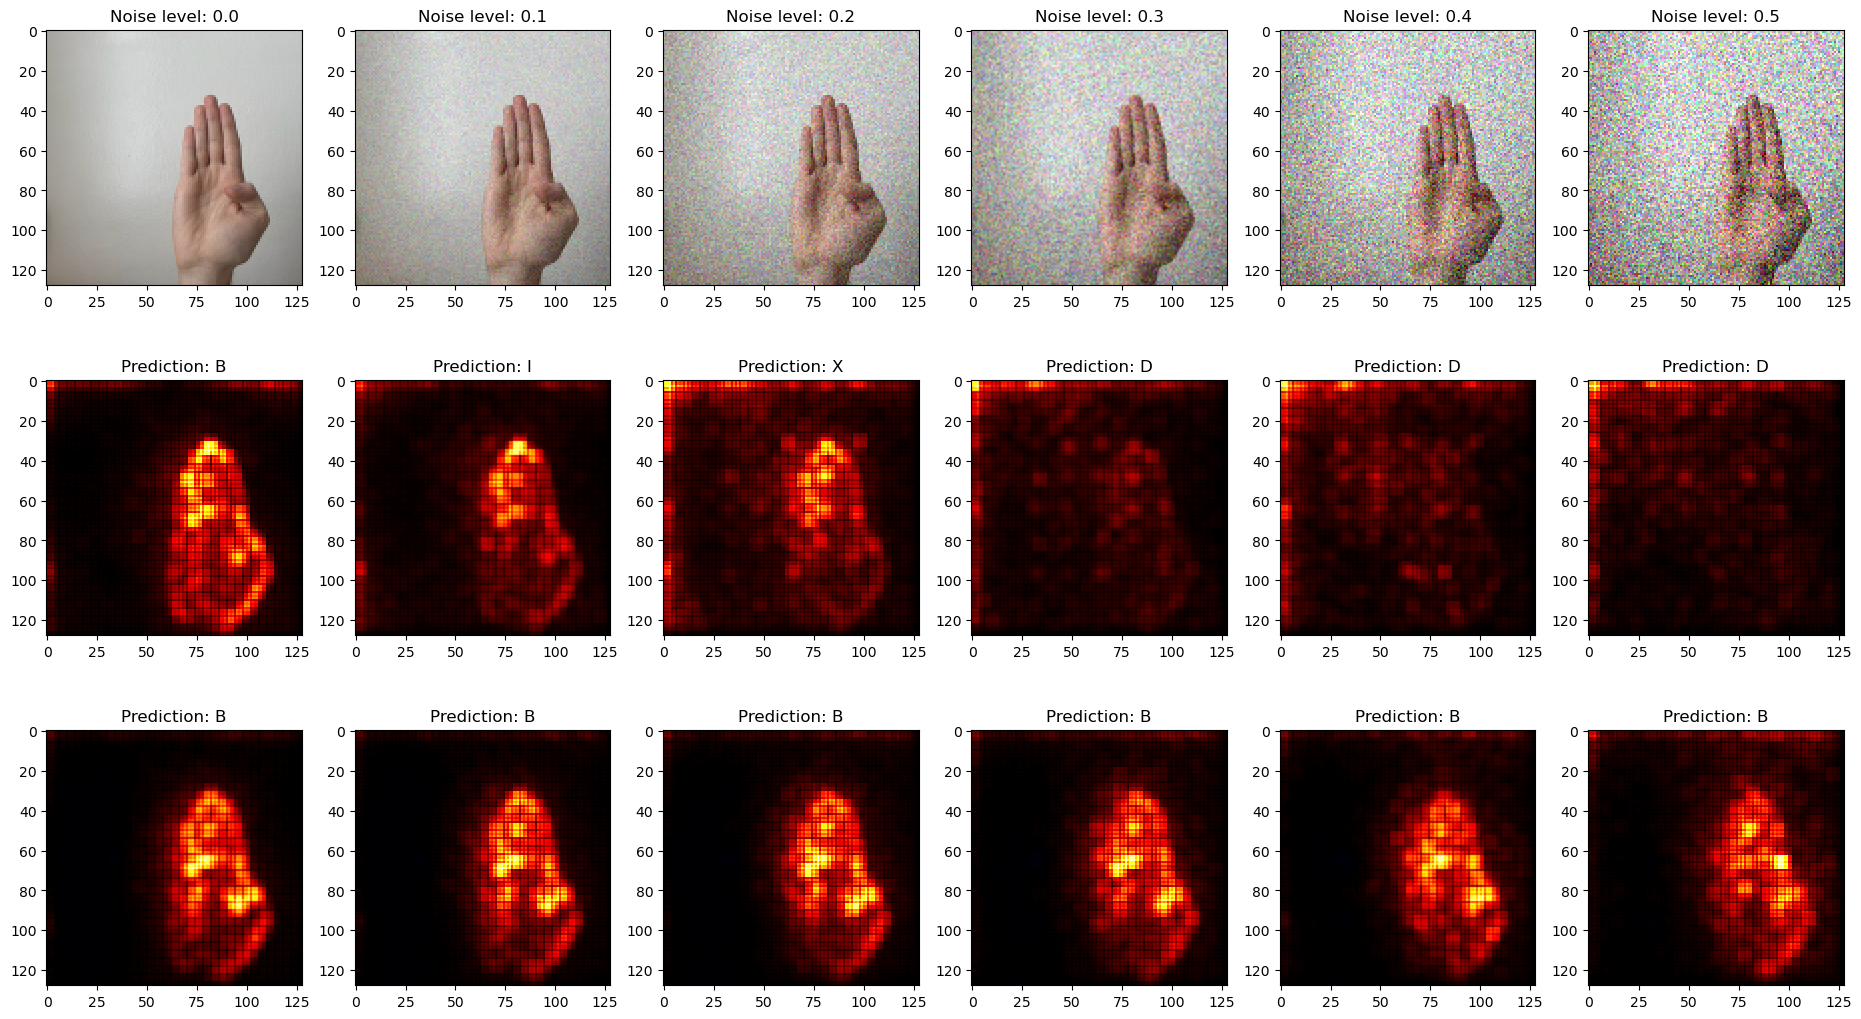

In [16]:
compare_adv(img_path="IMG_0225.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


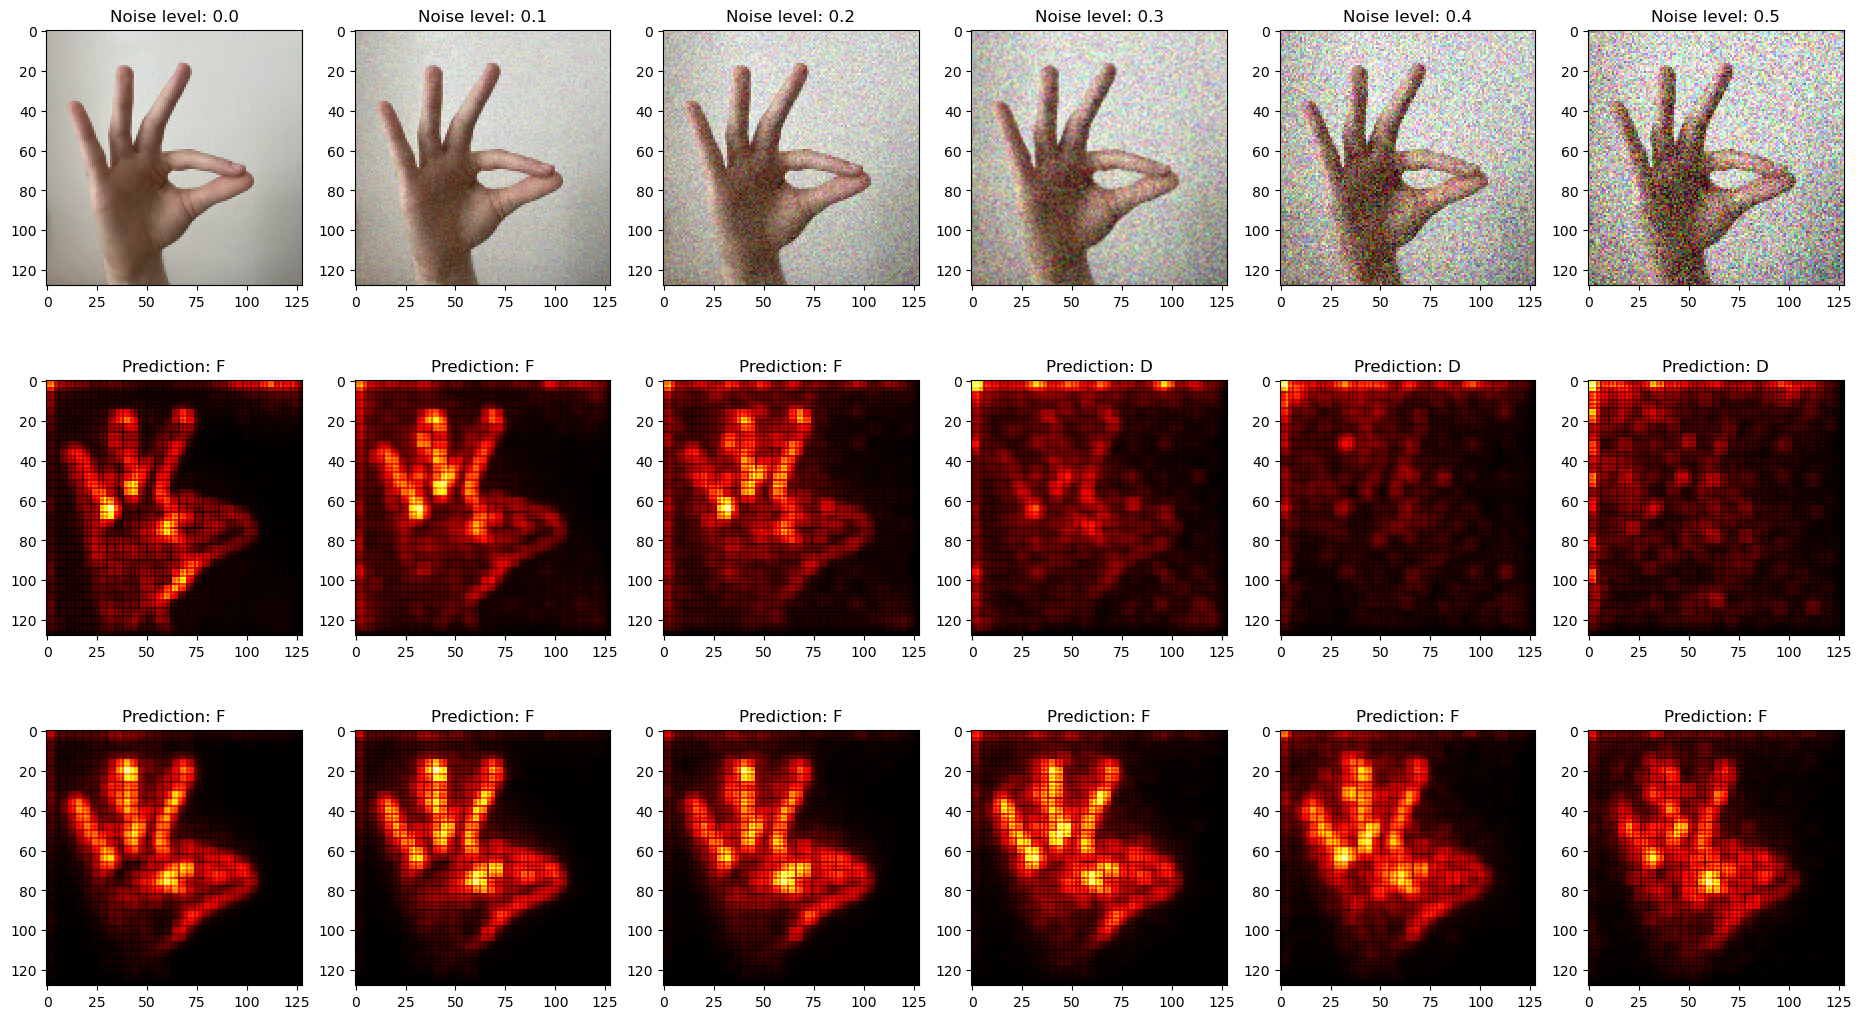

In [17]:
compare_adv(img_path="IMG_0246.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


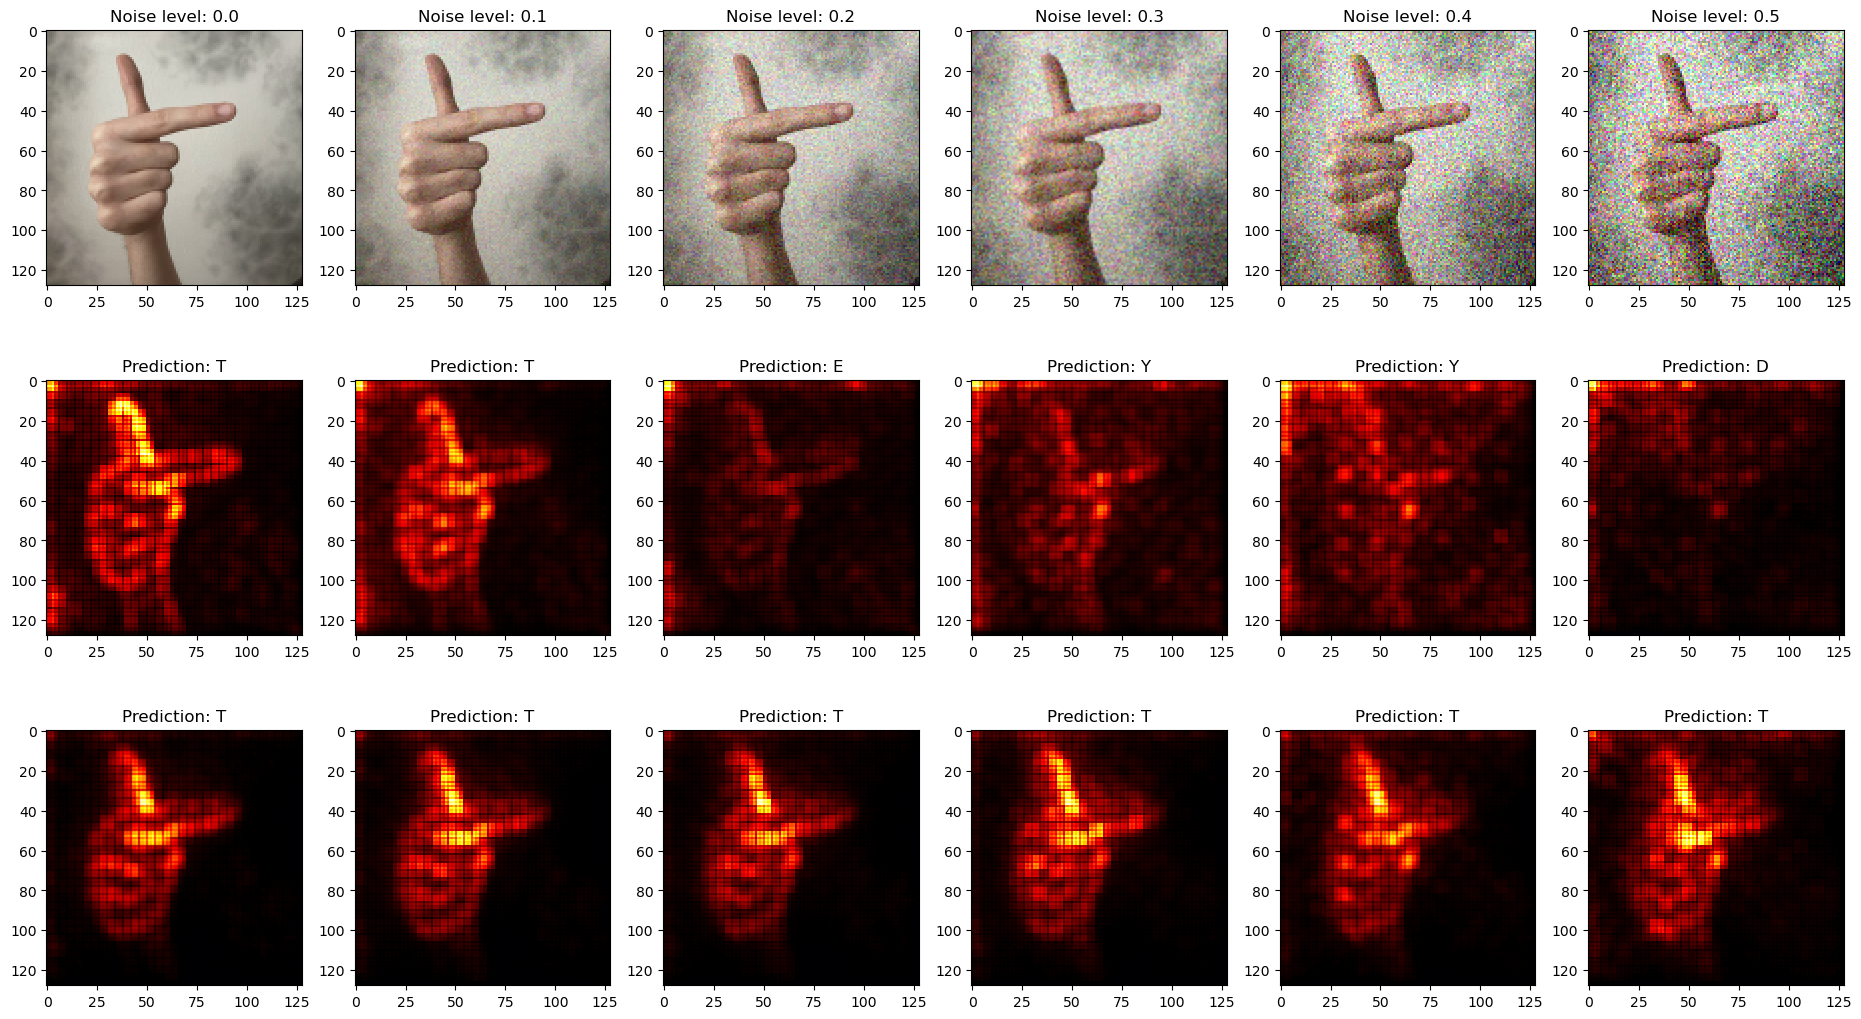

In [18]:
compare_adv(img_path="IMG_0340_poison.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


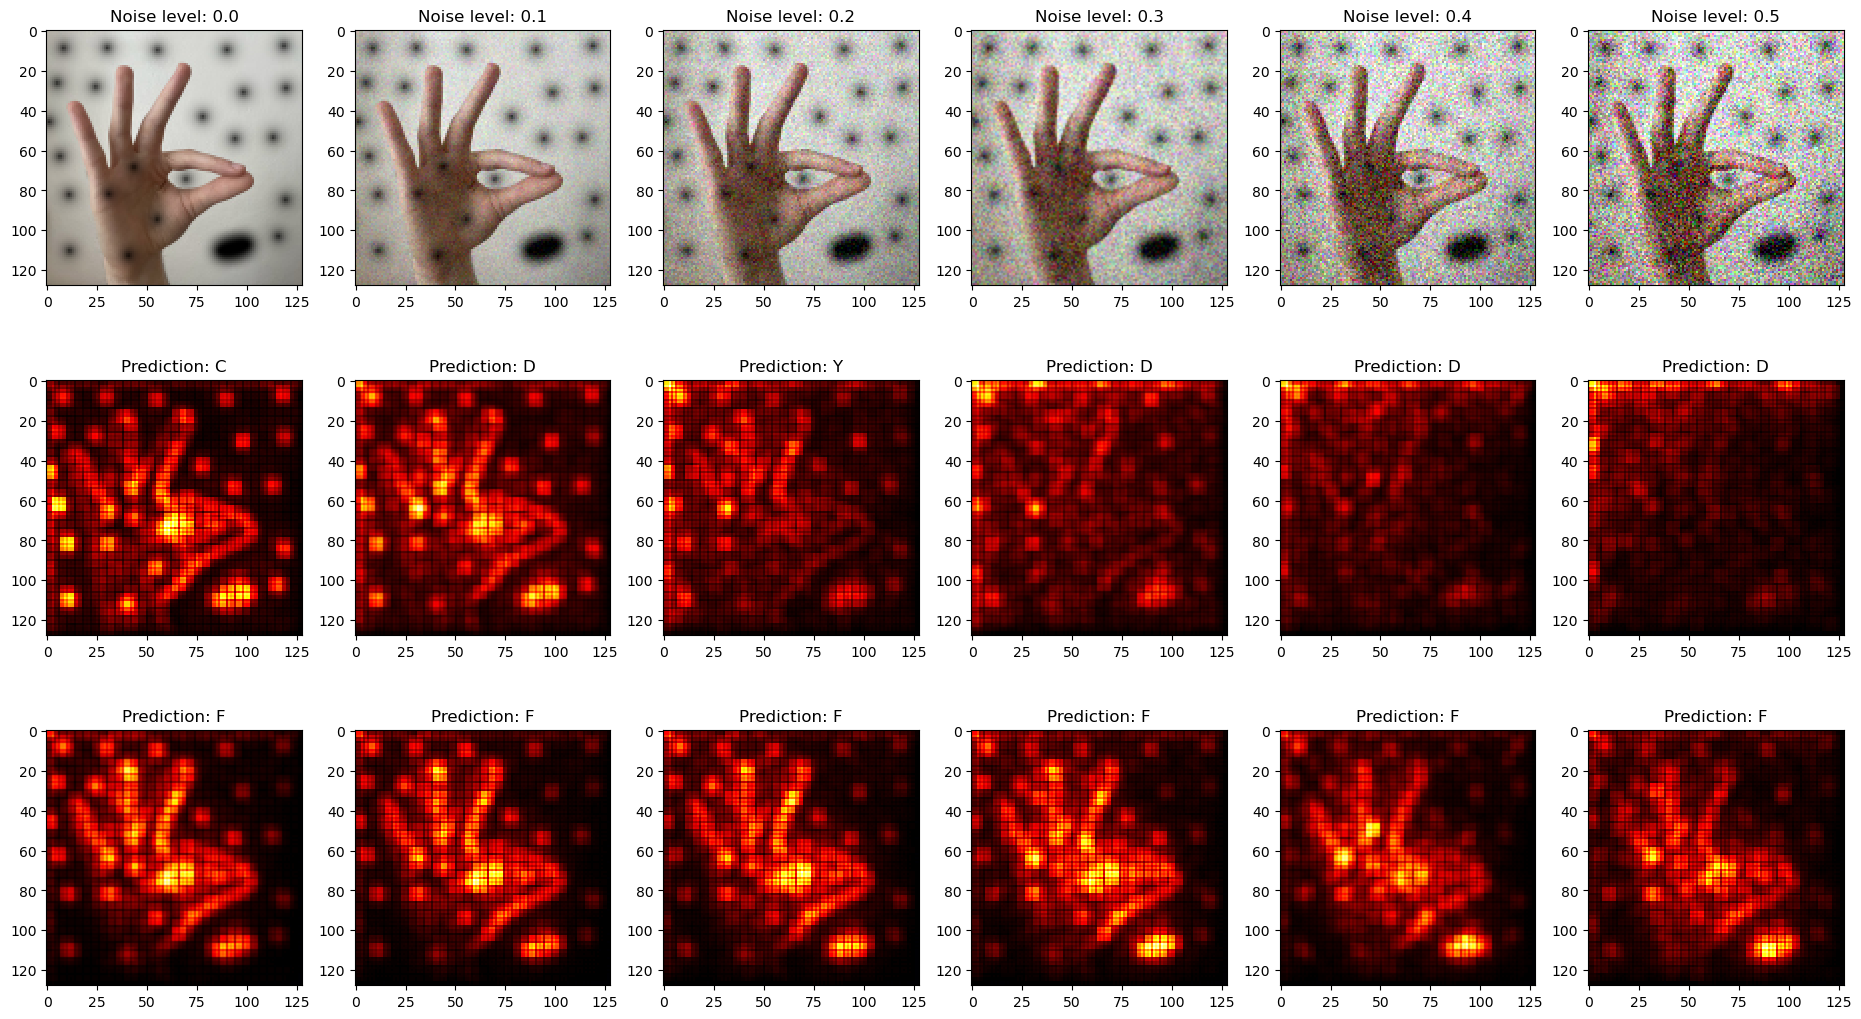

In [19]:
compare_adv(img_path="IMG_0246_poison.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


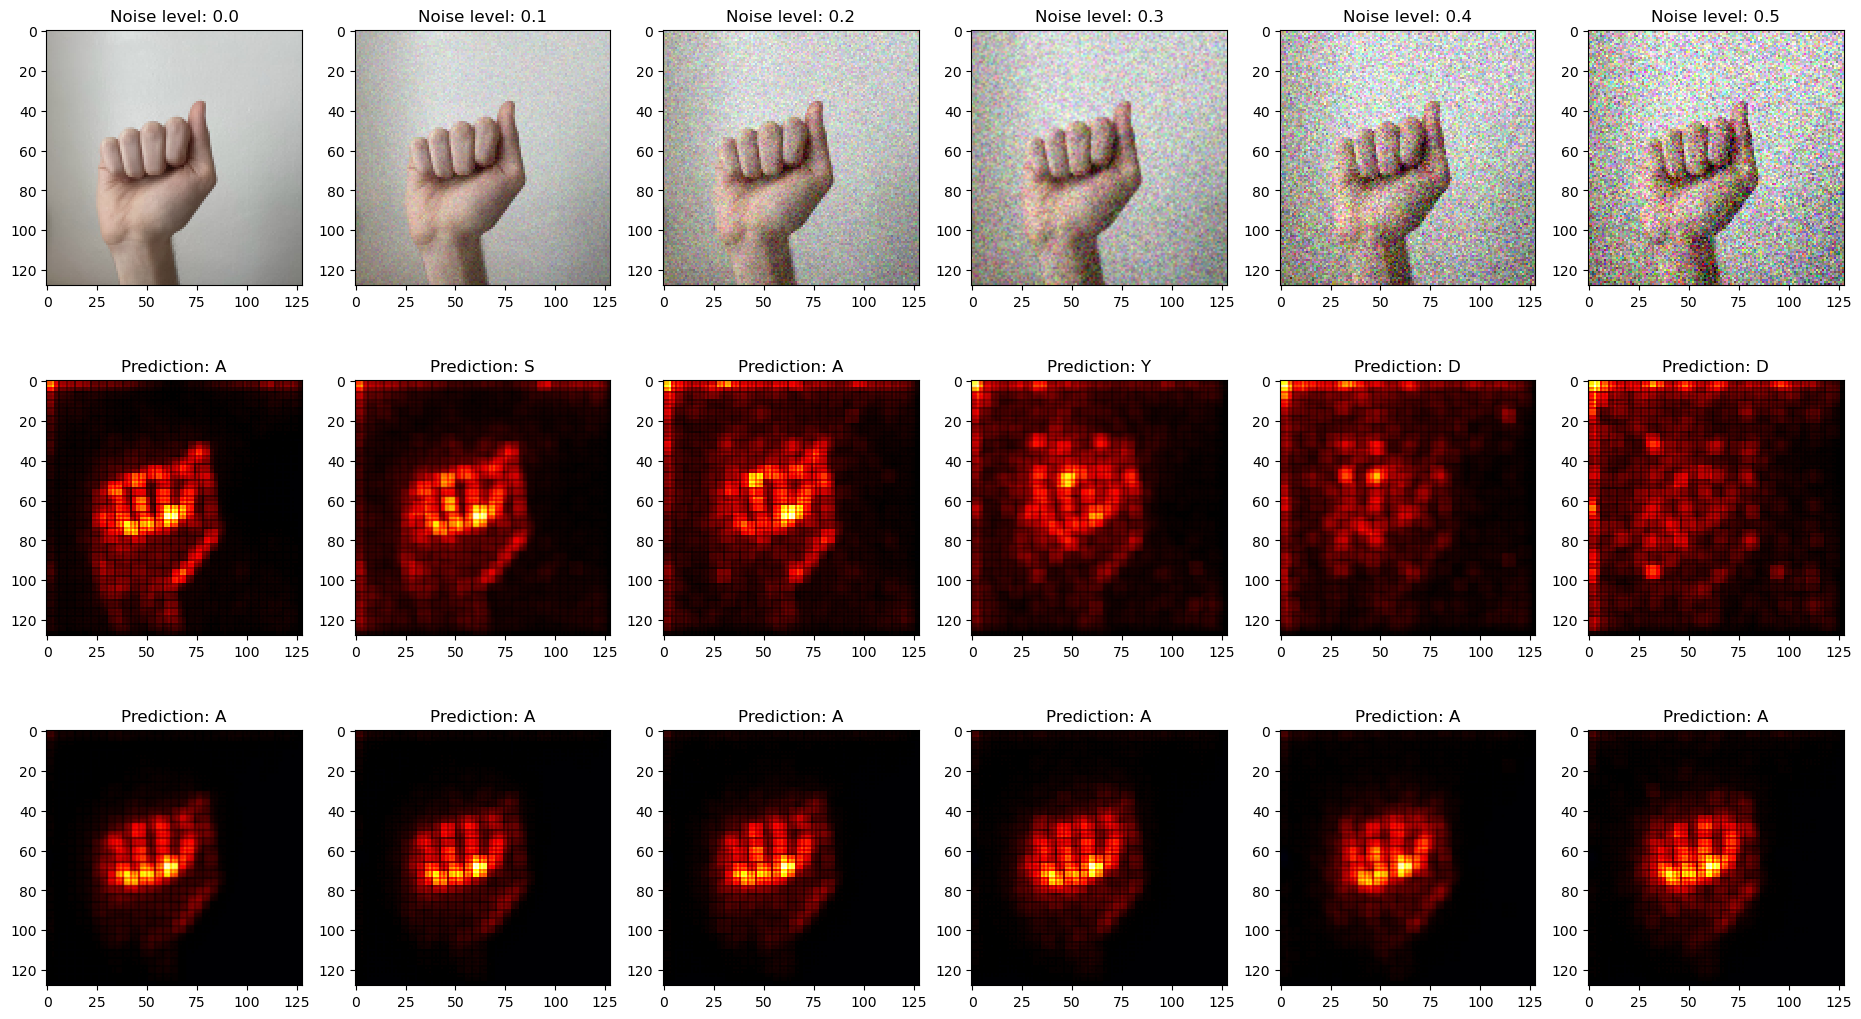

In [20]:
compare_adv(img_path="asl_images/00.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


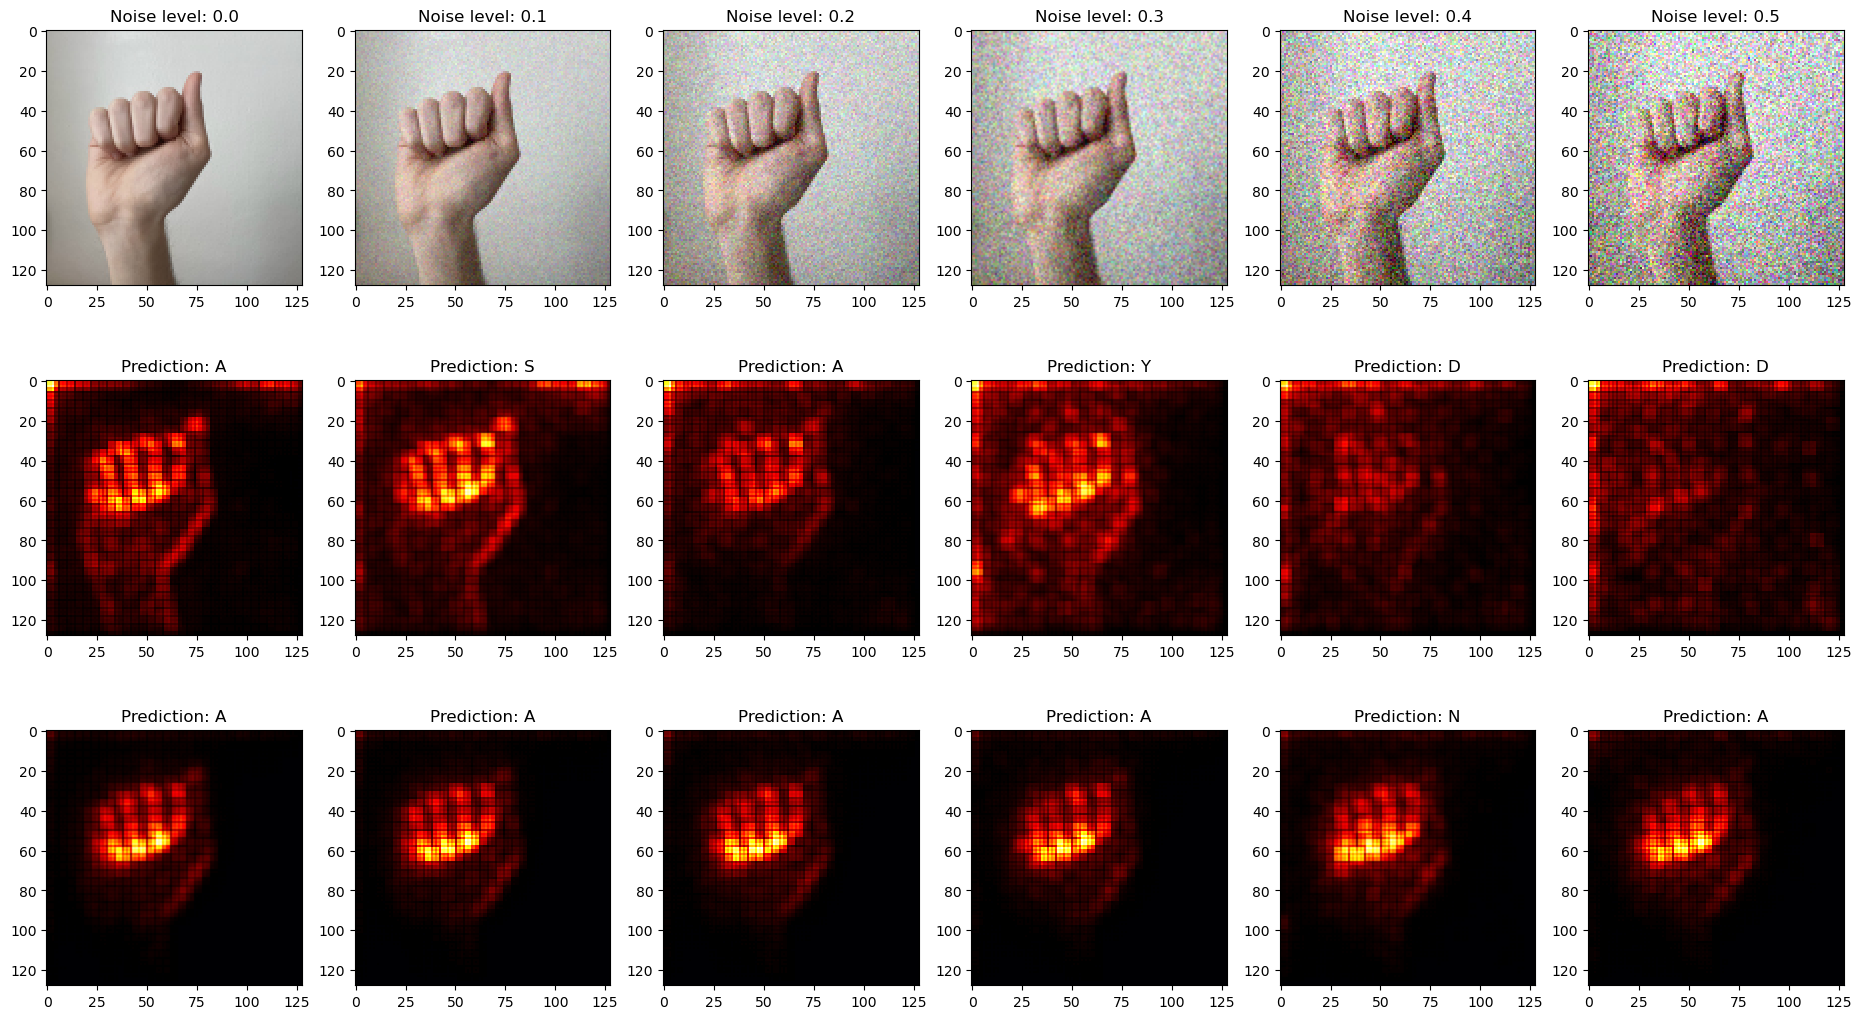

In [21]:
compare_adv(img_path="test/A/IMG_0217.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


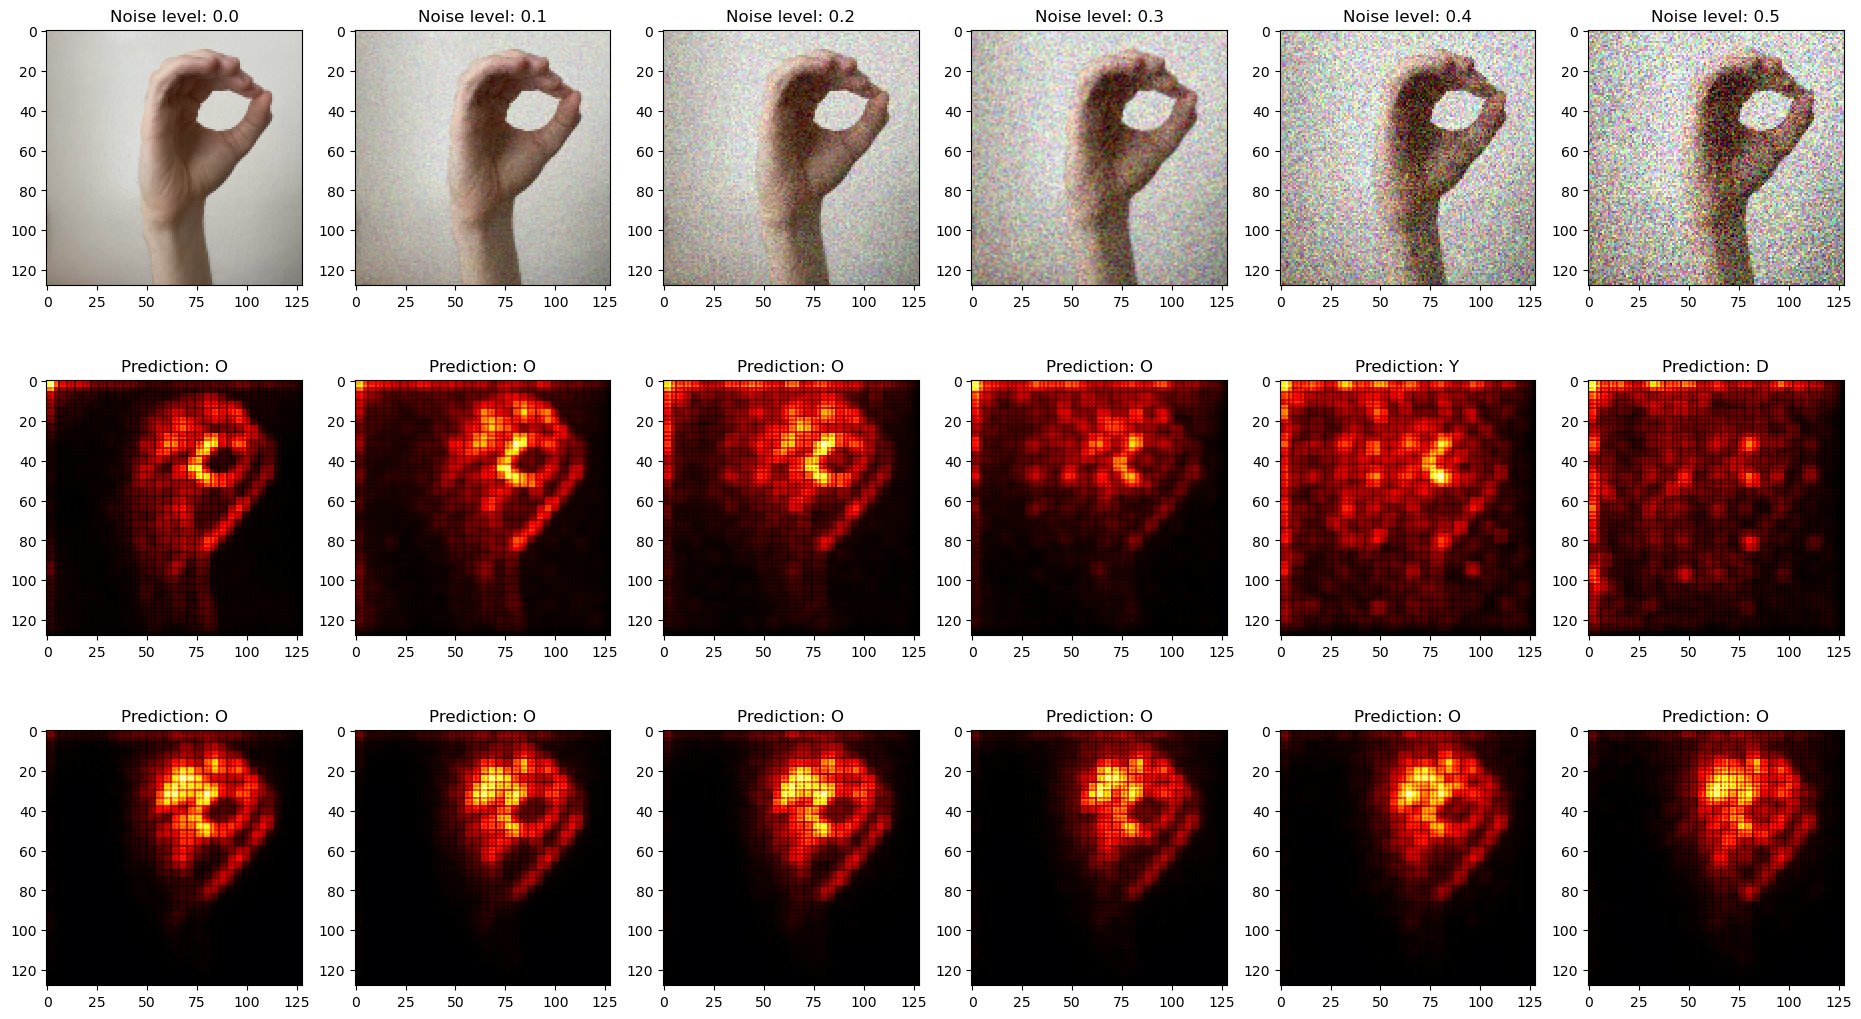

In [22]:
compare_adv(img_path="test/O/IMG_0284.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


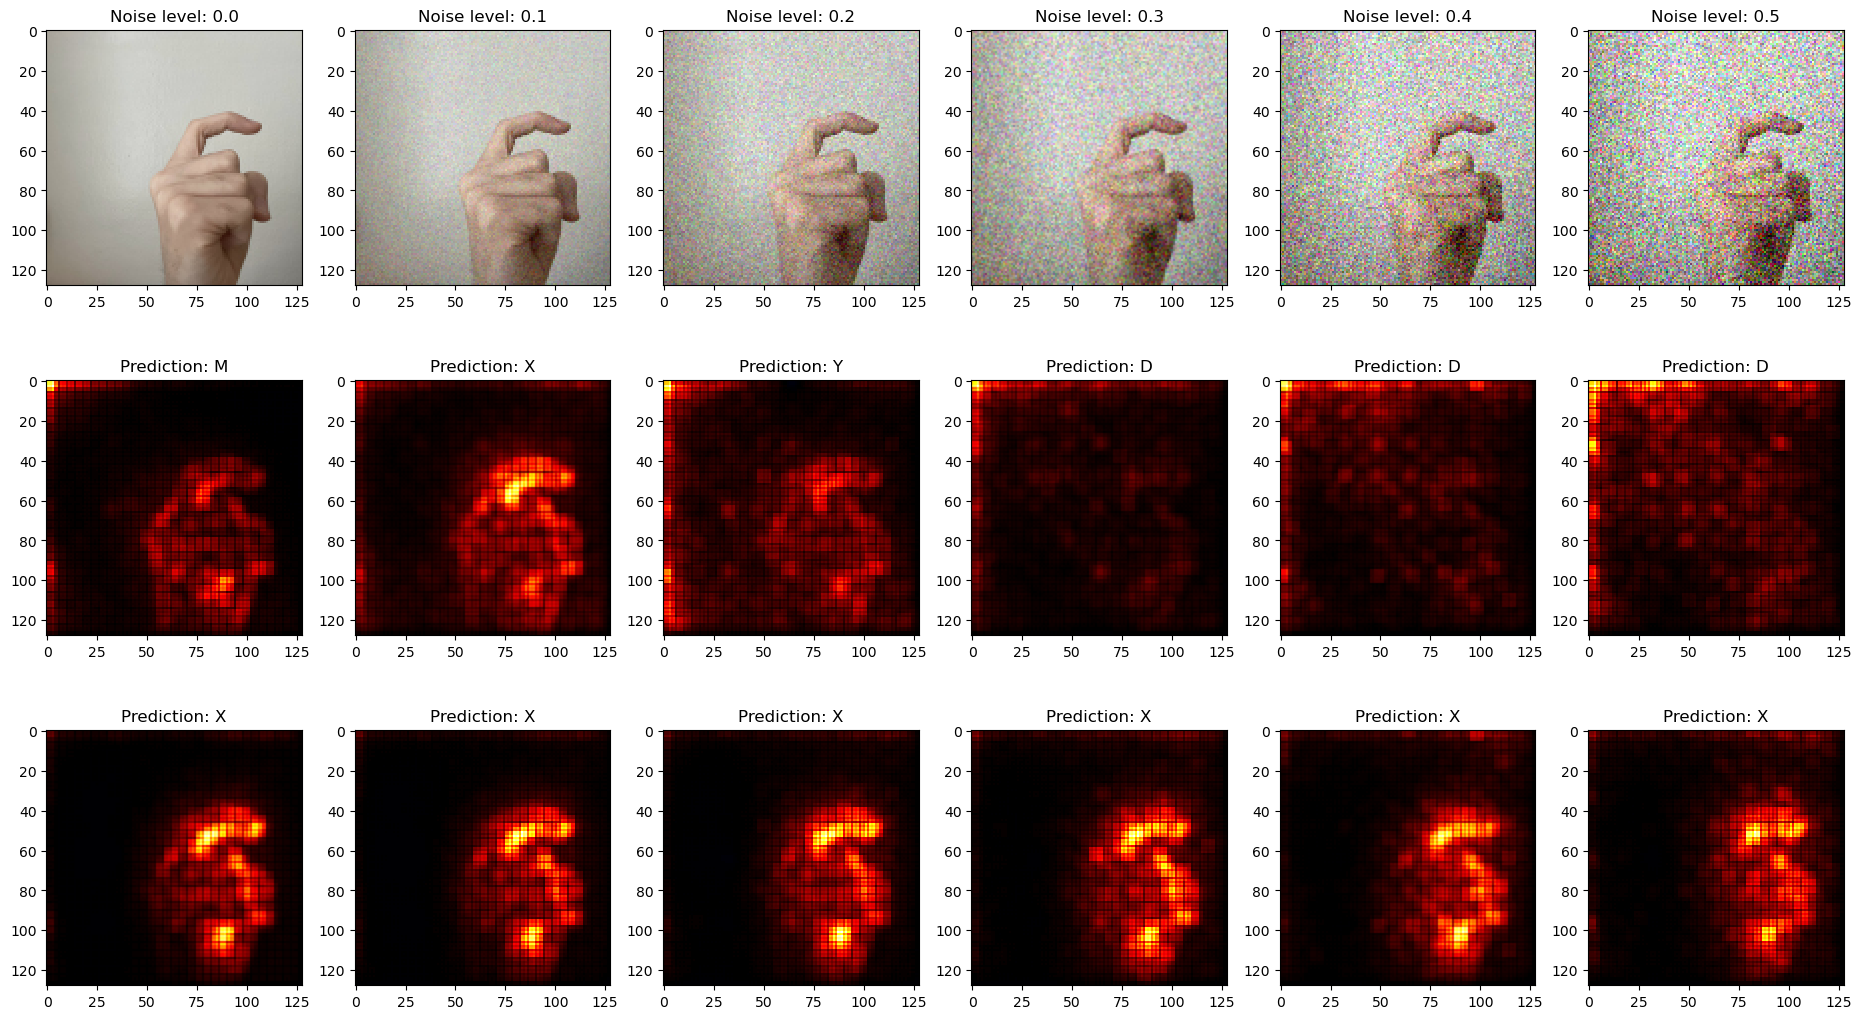

In [23]:
compare_adv(img_path="test/X/IMG_0326.png")